In [ ]:
!pip install backtrader

In [ ]:
!pip install datetime

In [ ]:
!pip install backtrader[plotting]

In [ ]:
!pip install git+https://github.com/blampe/IbPy.git

Id,,len,datetime,open,high,low,close,volume,openinterest,myStrategy,len,datetime,Broker,len,cash,value,BuySell,len,buy,sell,Trades - Net Profit/Loss,len,pnlplus,pnlminus
1,,1,2015-01-05 00:00:00,17325.6796875,17540.919921875,17219.220703125,17408.7109375,116500.0,,myStrategy,1,735603.0,Broker,1,1000000.0,1000000.0,BuySell,1,,,Trades - Net Profit/Loss,1,,
2,,2,2015-01-06 00:00:00,17101.580078125,17111.359375,16881.73046875,16883.189453125,166000.0,,myStrategy,2,735604.0,Broker,2,1000000.0,1000000.0,BuySell,2,,,Trades - Net Profit/Loss,2,,
3,,3,2015-01-07 00:00:00,16808.259765625,16974.609375,16808.259765625,16885.330078125,138600.0,,myStrategy,3,735605.0,Broker,3,1000000.0,1000000.0,BuySell,3,,,Trades - Net Profit/Loss,3,,
4,,4,2015-01-08 00:00:00,17067.400390625,17243.7109375,17016.08984375,17167.099609375,140600.0,,myStrategy,4,735606.0,Broker,4,1000000.0,1000000.0,BuySell,4,,,Trades - Net Profit/Loss,4,,
5,,5,2015-01-09 00:00:00,17318.740234375,17342.650390625,17129.529296875,17197.7

2016-10-13 00:00:00, 買い約定, 取引量:25.55, 価格:16774.24, 取引額:-429417.80, 手数料:214.28
2016-10-13 00:00:00, 買い約定, 取引量:25.55, 価格:16774.24, 取引額:428565.01, 手数料:214.28
2016-10-14 00:00:00, 取引損益, 総額:852.80, 純額:423.81
437,,437,2016-10-14 00:00:00,16751.0390625,16866.560546875,16727.779296875,16856.369140625,109400.0,,myStrategy,437,736251.0,Broker,437,396025.7765921892,826689.0934128202,BuySell,437,16476.862607421874,,Trades - Net Profit/Loss,437,423.8061557712339,
438,,438,2016-10-17 00:00:00,16871.83984375,16954.439453125,16821.490234375,16900.119140625,95100.0,,myStrategy,438,736254.0,Broker,438,396025.7765921892,827806.8620113669,BuySell,438,,,Trades - Net Profit/Loss,438,,
439,,439,2016-10-18 00:00:00,16862.310546875,16966.900390625,16844.169921875,16963.609375,98600.0,,myStrategy,439,736255.0,Broker,439,396025.7765921892,829428.9737896239,BuySell,439,,,Trades - Net Profit/Loss,439,,
440,,440,2016-10-19 00:00:00,16952.91015625,17016.66015625,16938.4609375,16998.91015625,101700.0,,myStrategy,440,

2018-08-30 00:00:00, 買い約定, 取引量:25.55, 価格:22869.50, 取引額:-567295.56, 手数料:292.15
2018-08-30 00:00:00, 買い約定, 取引量:25.55, 価格:22869.50, 取引額:584292.78, 手数料:292.15
2018-08-31 00:00:00, 取引損益, 総額:-16997.22, 純額:-17573.01
903,,903,2018-08-31 00:00:00,22733.25,22890.609375,22678.029296875,22865.150390625,68100.0,,myStrategy,903,736937.0,Broker,903,262788.29432803264,846969.9425037794,BuySell,903,22337.858857421874,,Trades - Net Profit/Loss,903,,-17573.01261990697
904,,904,2018-09-03 00:00:00,22819.169921875,22820.48046875,22684.4296875,22707.380859375,49900.0,,myStrategy,904,736940.0,Broker,904,262788.29432803264,842939.089296038,BuySell,904,,,Trades - Net Profit/Loss,904,,
905,,905,2018-09-04 00:00:00,22740.05078125,22753.1796875,22612.150390625,22696.900390625,52300.0,,myStrategy,905,736941.0,Broker,905,262788.29432803264,842671.3238362254,BuySell,905,,,Trades - Net Profit/Loss,905,,
906,,906,2018-09-05 00:00:00,22663.80078125,22692.25,22570.51953125,22580.830078125,65400.0,,myStrategy,906,736942.

<IPython.core.display.Javascript object>


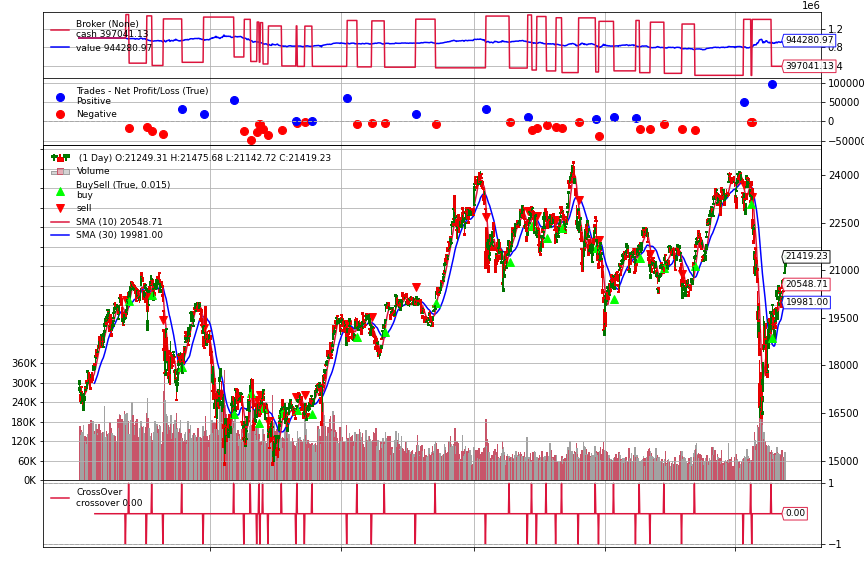

CPU times: user 2.53 s, sys: 442 ms, total: 2.97 s
Wall time: 5.27 s


[[<Figure size 864x576 with 5 Axes>]]

In [1]:
%%time
# ↑セルの処理時間を計算　セルの最初に単独で書く

import os # ディレクトリ作成、パス結合、ファイル削除
import pandas as pd # pandasデータフレームを使用
import datetime

#dir_name = 'hst_20191128' # ヒストリカルデータのフォルダ名

#input_csv = os.path.join(os.getcwd(), dir_name, 'USDJPY_20190930.csv') # csvファイルのフルパス

df = pd.read_csv('tsd.csv') # csvファイルをPandasデータフレームに読み込む

#print(df.tail())

#日時列をdatatime型にしてインデックスにして、元の列は削除する
df = df.set_index(pd.to_datetime(df['Date'])).drop('Date', axis=1) 

import backtrader as bt # Backtrader
import backtrader.feeds as btfeed # データ変換


data = btfeed.PandasData(dataname=df) # PandasのデータをBacktraderの形式に変換する

class myStrategy(bt.Strategy): # ストラテジー
    
    n1 = 10 # 終値のSMA（単純移動平均）の期間
    n2 = 30 # 終値のSMA（単純移動平均）の期間

    def log(self, txt, dt=None, doprint=False): # ログ出力用のメソッド
        if doprint:
            print('{0:%Y-%m-%d %H:%M:%S}, {1}'.format(
                dt or self.datas[0].datetime.datetime(0),
                txt
            ))

    def __init__(self): # 事前処理
        self.sma1 = bt.indicators.SMA(self.data.close, period=self.n1) # SMA（単純移動平均）のインジケータを追加
        self.sma2 = bt.indicators.SMA(self.data.close, period=self.n2) # SMA（単純移動平均）のインジケータを追加
        self.crossover = bt.indicators.CrossOver(self.sma1, self.sma2) # sma1がsma2を上回った時に1、下回ったときに-1を返す
        
    def next(self): # 行ごとに呼び出される
        if self.crossover > 0: # SMA1がSMA2を上回った場合
            if self.position: # ポジションを持っている場合
                self.close() # ポジションをクローズする
            self.buy() # 買い発注
        elif self.crossover < 0: # SMA1がSMA2を下回った場合
            if self.position: # ポジションを持っている場合
                self.close() # ポジションをクローズする
            self.sell() # 売り発注
            
    def notify_order(self, order): # 注文のステータスの変更を通知する
        if order.status in [order.Submitted, order.Accepted]: # 注文の状態が送信済or受理済の場合
            return # 何もしない
        
        if order.status in [order.Completed]: # 注文の状態が完了済の場合
            if order.isbuy(): # 買い注文の場合
                self.log('買い約定, 取引量:{0:.2f}, 価格:{1:.2f}, 取引額:{2:.2f}, 手数料:{3:.2f}'.format(
                        order.executed.size, # 取引量
                        order.executed.price, # 価格
                        order.executed.value, # 取引額
                        order.executed.comm # 手数料
                    ), 
                    dt=bt.num2date(order.executed.dt), # 約定の日時をdatetime型に変換
                    doprint=True # Trueの場合出力
                )
            elif order.issell(): # 売り注文の場合
                self.log('売り約定, 取引量:{0:.2f}, 価格:{1:.2f}, 取引額:{2:.2f}, 手数料:{3:.2f}'.format(
                        order.executed.size, # 取引量
                        order.executed.price, # 価格
                        order.executed.value, # 取引額
                        order.executed.comm # 手数料
                    ), 
                    dt=bt.num2date(order.executed.dt), # 約定の日時をdatetime型に変換
                    doprint=True # Trueの場合ログを出力する
                )
                
        # 注文の状態がキャンセル済・マージンコール（証拠金不足）・拒否済の場合
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('注文 キャンセル・マージンコール（証拠金不足）・拒否',
                doprint=True
            )

    def notify_trade(self, trade): # 取引の開始/更新/終了を通知する
        if trade.isclosed: # トレードが完了した場合
            self.log('取引損益, 総額:{0:.2f}, 純額:{1:.2f}'.format(
                    trade.pnl, # 損益
                    trade.pnlcomm # 手数料を差し引いた損益
                ),
                doprint=True # Trueの場合ログを出力する
            )

# バックテストの設定
cerebro = bt.Cerebro() # Cerebroエンジンをインスタンス化
cerebro.addstrategy(myStrategy) # ストラテジーを追加
data = btfeed.PandasData(dataname=df) # Cerebro形式にデータを変換
cerebro.adddata(data) # データをCerebroエンジンに追加
cerebro.broker.setcash(1000000.0) # 所持金を設定
cerebro.broker.setcommission(commission=0.0005) # 手数料（スプレッド）を0.05%に設定
cerebro.addsizer(bt.sizers.PercentSizer, percents=50) # デフォルト（buy/sellで取引量を設定していない時）の取引量を所持金に対する割合で指定する
startcash = cerebro.broker.getvalue() # 開始時の所持金
cerebro.broker.set_coc(True) # 発注時の終値で約定する

# 解析の設定
import backtrader.analyzers as btanalyzers # バックテストの解析用ライブラリ
cerebro.addanalyzer(btanalyzers.DrawDown, _name='myDrawDown') # ドローダウン
cerebro.addanalyzer(btanalyzers.SQN, _name='mySQN') # SQN
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='myTradeAnalyzer') # トレードの勝敗等の結果

thestrats = cerebro.run() # バックテストを実行
thestrat = thestrats[0] # 解析結果の取得

# 評価値の表示
print('Start                 :{0:%Y/%m/%d %H:%M:%S}'.format( # ヒストリカルデータの開始日時
    pd.to_datetime(df.index.values[0])
))
print('End                   :{0:%Y/%m/%d %H:%M:%S}'.format (# ヒストリカルデータの開始日時
    pd.to_datetime(df.index.values[-1])
))
print('Duration              :{0}'.format( # ヒストリカルデータの期間の長さ
    pd.to_datetime(df.index.values[-1]) - pd.to_datetime(df.index.values[0])
))
print('Exposure[%]           :{0:.2f}'.format( # ポジションを持っていた期間の割合（ポジションを持っていた期間÷全期間×100）
    thestrat.analyzers.myTradeAnalyzer.get_analysis().len.total / len(df) * 100
))
print('Equity Final[$]       :{0:.2f}'.format( # 所持金の最終値（closedした取引）
    startcash + thestrat.analyzers.myTradeAnalyzer.get_analysis().pnl.net.total
))  
print('Return[%]             :{0:.2f}'.format( # 利益率=損益÷開始時所持金×100
    thestrat.analyzers.myTradeAnalyzer.get_analysis().pnl.net.total / startcash * 100
))
print('Buy & Hold Return[%]  :{0:.2f}'.format( # （（終了時の終値 - 開始時の終値）÷ 開始時の終値）の絶対値×100
    (df['Close'][-1] - df['Close'][0]) / df['Close'][0] * 100
))
print('Max. Drawdown[%]      :{0:.2f}'.format( # 最大下落率
    thestrat.analyzers.myDrawDown.get_analysis().max.drawdown
))
print('Max. Drawdown Duration:{0}'.format( # 最大下落期間
    pd.Timedelta(minutes=thestrat.analyzers.myDrawDown.get_analysis().max.len)
))
print('Trades                :{0}'.format( # 取引回数
    thestrat.analyzers.myTradeAnalyzer.get_analysis().total.closed
))
winrate = ( # 勝率
    thestrat.analyzers.myTradeAnalyzer.get_analysis().won.total 
    / thestrat.analyzers.myTradeAnalyzer.get_analysis().total.closed
)
lostrate = ( # 敗率
    thestrat.analyzers.myTradeAnalyzer.get_analysis().lost.total 
    / thestrat.analyzers.myTradeAnalyzer.get_analysis().total.closed
)
print('Win Rate[%]           :{0:.2f}'.format( # 勝率=勝ち取引回数÷全取引回数×100
    winrate * 100
))
print('Best Trade[%]         :{0:.2f}'.format( # 1回の取引での利益の最大値÷所持金×100
    thestrat.analyzers.myTradeAnalyzer.get_analysis().won.pnl.max / startcash * 100
))
print('Worst Trade[%]        :{0:.2f}'.format( # 1回の取引での損失の最大値÷所持金×100
    thestrat.analyzers.myTradeAnalyzer.get_analysis().lost.pnl.max / startcash * 100
))
print('Avg. Trade[%]         :{0:.2f}'.format( # 損益の平均値÷所持金×100
    thestrat.analyzers.myTradeAnalyzer.get_analysis().pnl.net.average / startcash * 100
))
print('Max. Trade Duration   :{0}'.format( # 1回の取引での最長期間
    pd.Timedelta(minutes=thestrat.analyzers.myTradeAnalyzer.get_analysis().len.max)
))
print('Avg. Trade Duration   :{0}'.format( # 1回の取引での平均期間
    pd.Timedelta(minutes=thestrat.analyzers.myTradeAnalyzer.get_analysis().len.average)
))
print('Expectancy[%]         :{0:.2f}'.format( # 期待値=平均利益×勝率＋平均損失×敗率
    thestrat.analyzers.myTradeAnalyzer.get_analysis().won.pnl.average * winrate 
    + thestrat.analyzers.myTradeAnalyzer.get_analysis().lost.pnl.average * lostrate
))
print('SQN                   :{0:.2f}'.format( # SQN システムの評価値
    thestrat.analyzers.mySQN.get_analysis().sqn
))

# グラフの設定
%matplotlib inline
# ↑グラフをNotebook内に描画する

import matplotlib.pylab as pylab # グラフ描画用ライブラリ

pylab.rcParams['figure.figsize'] = 12, 8  # グラフのサイズ
cerebro.plot(
    style = 'candle', # ロウソク表示にする
    barup = 'green', barupfill = False, # 陽線の色、塗りつぶし設定
    bardown = 'red', bardownfill = False, # 陰線の色、塗りつぶし設定
    fmt_x_data = '%Y-%m-%d %H:%M:%S' # 時間軸のマウスオーバー時の表示フォーマット
)




None
